In [1]:
import findspark
findspark.init('/usr/hdp/current/spark2-client')

import pyspark
from pyspark.sql.functions import lit, col, instr, expr, pow, round, bround, corr, count, mean, stddev_pop, min, max
from pyspark.sql.functions import monotonically_increasing_id, initcap, lower, upper, ltrim, rtrim, rpad, lpad, trim
from pyspark.sql.functions import regexp_replace, translate, regexp_extract, current_date, current_timestamp, struct
from pyspark.sql.functions import date_add, date_sub, datediff, months_between, to_date, to_timestamp, coalesce, split, size
from pyspark.sql.functions import array_contains, explode, udf
from pyspark.sql import HiveContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, when

from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DoubleType, FloatType, LongType

from datetime import datetime

In [2]:
def get_Spark():

    conf = pyspark.SparkConf().setAll([
        ('spark.submit.deployMode', 'client'), # deploy in yarn-client or yarn-cluster
        ('spark.executor.memory', '8g'),       # memory allocated for each executor
        ('spark.executor.cores', '3'),         # number of cores for each executor
        ('spark.executor.instances', '20'),    # number of executors in total
        ('spark.yarn.am.memory', '20g')])      # memory for spark driver (application master)
    spark = SparkSession.builder \
    .master("yarn") \
    .appName("result") \
    .enableHiveSupport() \
    .config(conf = conf) \
    .getOrCreate()

    return spark

spark = get_Spark()
spark_context = spark.sparkContext
hc = HiveContext(spark_context)

# Import taxi data from csv to Hive 

In [ ]:
import pandas as pd
data = pd.read_csv("taxi.csv")

In [ ]:
data.head()

In [ ]:
from pyspark.sql.types import *

mySchema = StructType([ StructField("id", IntegerType(), True)\
                       ,StructField("vin", StringType(), True)\
                       ,StructField("beginning_date", StringType(), True)])

In [ ]:
df = spark.createDataFrame(data,schema=mySchema)
type(df)

In [ ]:
df.registerTempTable('update_dataframe')
sql_cmd = """CREATE TABLE guobiao_tsp_tbls.taxi_list AS SELECT vin,beginning_date FROM update_dataframe"""
print(sql_cmd)
hc.sql(sql_cmd)
print('Table guobiao_tsp_tbls.taxi_list creation done.')

# Import Daily Stats from Hive to Spark dataframe

In [3]:
def hive2spark(hc, query):
    spark_df = hc.sql("""{}""".format(query))
    return spark_df

In [4]:
query = """select t1.*, t2.vintype from guobiao_tsp_tbls.daily_stats t1 left outer join guobiao_tsp_tbls.vintypes t2
on t1.vin = t2.vin
where vintype='A5HEV' or vintype='A75' or vintype='A2APHEV'
"""

In [5]:
df_daily_stats = hive2spark(hc, query)

In [ ]:
df_daily_stats.head()

In [ ]:
df_daily_stats.show(1)

# Calculate unique VIN

In [ ]:
resfile = '/home/wchen/ne/res.csv'

In [ ]:
from datetime import datetime, date
end_date = date.today()
start_date = date(2017, 8, 5)
print(end_date)

In [ ]:
from datetime import timedelta
dates = []
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days + 1)):
        yield start_date + timedelta(n)
for single_date in daterange(start_date, end_date):
    dates.append(single_date.strftime('%Y-%m-%d'))

In [ ]:
from pyspark.sql.functions import col
vins = df_daily_stats.filter(df_daily_stats.day=='2018-11-08').select("vin").collect()
print(vins) #df to list

In [ ]:
type(vins)

In [ ]:
vins = []

In [ ]:
type(vins)

In [ ]:
with open(resfile, "a") as myfile:
    vinset = set()
    for day in dates:
        vins = df_daily_stats.filter(df_daily_stats.day==day).select("vin").collect()
        print(len(vins))
        vinset.update(vins)
        
        myfile.write(day + ',' + str(len(vinset)) + '\n')
        print(day + ',' + str(len(vinset)) + '\n')
myfile.close()

In [ ]:
import pandas as pd 
data = pd.read_csv("res.csv") 

In [ ]:
data.head()

In [ ]:
data.dtypes

In [ ]:
pd.to_datetime(data.day, format='%Y-%m-%d')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
data = data.set_index(data.day)
#data.reset_index(inplace=True)

In [ ]:
data.columns

In [ ]:
type(data.day)

In [ ]:
data.index

In [ ]:
sns.tsplot([data.count])
plt.show()

# Create histogram from spark dataframe

In [ ]:
from pyspark.sql import functions as F

update_func = (F.when(F.col('vintype') == 'A5HEV', 'GE3').when(F.col('vintype') == 'A75', 'GE3-530')
                .when(F.col('vintype') == 'A2APHEV', 'GS4-PHEV').otherwise(F.col('vintype')))
df_test = df_daily_stats.withColumn('new_vintype', update_func)

In [ ]:
df_test.select('vintype').distinct().show()

In [ ]:
from pyspark.sql import functions as func
df1=df_daily_stats.filter(col("vintype").isin(['A5HEV'])).groupBy("vin").agg(func.sum("kwh_charged_plugin").alias('Total kwh charged'),func.max("odometer_reading_end").alias('End odo reading'))
df2=df_daily_stats.filter(col("vintype").isin(['A2APHEV'])).groupBy("vin").agg(func.sum("kwh_charged_plugin").alias('Total kwh charged'),func.max("odometer_reading_end").alias('End odo reading'))
df3=df_daily_stats.filter(col("vintype").isin(['A75'])).groupBy("vin").agg(func.sum("kwh_charged_plugin").alias('Total kwh charged'),func.max("odometer_reading_end").alias('End odo reading'))

In [ ]:
df3_new=df3.withColumn("Energy Efficiency", df3["Total kwh charged"]/df3["End odo reading"]*100)

In [ ]:
df3_new=df3_new.filter(df3_new["Energy Efficiency"]>2)

In [ ]:
df1_new=df1.withColumn("Energy Efficiency", df1["Total kwh charged"]/df1["End odo reading"]*100)

In [ ]:
df1_new=df1_new.filter(df1_new["Energy Efficiency"]>2)

In [ ]:
df3_new.show(5)

In [ ]:
df3_pd_new = df3_new.toPandas()  

In [ ]:
df1_pd_new = df1_new.toPandas()  

In [ ]:
df3_pd_new.head()

In [ ]:
#print(df3_pd_new['Energy Efficiency'])

In [ ]:
import seaborn as sns
sns.distplot(df3_pd_new['Energy Efficiency'].dropna())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize": (13, 4)})
sns.set_context('talk')
bins = np.linspace(5, 35, 20)
y = df1_pd_new[df3_pd_new['Energy Efficiency']>2]['Energy Efficiency'].dropna()
ax = plt.hist(y, bins=bins)
plt.xlabel('Kwh/100km')
plt.ylabel('Frequency')
plt.title('GE3 Energy Efficiency')
#ax = sns.distplot(x, bins=bins)
#ax.set_title('A75 Energy Efficiency')
#ax.set_xlabel('Kwh/100km')
#ax.set_xlim(0,100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize": (13, 4)})
sns.set_context('talk')
bins = np.linspace(5, 35, 20)
x = df3_pd_new[df3_pd_new['Energy Efficiency']>2]['Energy Efficiency'].dropna()
ax = plt.hist(x, bins=bins)
plt.xlabel('Kwh/100km')
plt.ylabel('Frequency')
plt.title('GE3-530 Energy Efficiency')
#ax = sns.distplot(x, bins=bins)
#ax.set_title('A75 Energy Efficiency')
#ax.set_xlabel('Kwh/100km')
#ax.set_xlim((5,35))

In [ ]:
df1_pd = df1.toPandas()  
df2_pd = df2.toPandas()  
df3_pd = df3.toPandas()  

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(rc={"figure.figsize": (15, 10)})
sns.set_context('talk')


bins = np.linspace(0, 100000, 20)

fig, axs = plt.subplots(2)

axs[0].hist(df1_pd['End odo reading'], label='GE3', bins=bins, alpha=0.5)
axs[0].hist(df2_pd['End odo reading'], label='GS4-PHEV', bins=bins, alpha=0.5)
axs[0].hist(df3_pd['End odo reading'], label='GE3-530', bins=bins, alpha=0.5)

for ax in axs:
    ax.set_ylabel('Number of Vehicles')
    ax.legend(loc=0)

axs[1].set_xlabel('End odo reading(in km)')
sns.despine()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(rc={"figure.figsize": (15, 10)})
sns.set_context('talk')


bins = np.linspace(0, 3000, 20)

fig, axs = plt.subplots(2)

axs[0].hist(df1_pd['Total kwh charged'], label='GE3', bins=bins, alpha=0.5)
axs[0].hist(df2_pd['Total kwh charged'], label='GS4-PHEV', bins=bins, alpha=0.5)
axs[0].hist(df3_pd['Total kwh charged'], label='GE3-530', bins=bins, alpha=0.5)

for ax in axs:
    ax.set_ylabel('Number of Vehicles')
    ax.legend(loc=0)

axs[1].set_xlabel('Total charge (in kwh)')
sns.despine()

In [ ]:
from pyspark.sql import functions as func
d1=df_daily_stats.filter(col("vintype").isin(['A5HEV'])).groupBy("vin").agg(func.mean("kwh_efficiency").alias('Energy Efficiency'))
d2=df_daily_stats.filter(col("vintype").isin(['A2APHEV'])).groupBy("vin").agg(func.mean("kwh_efficiency").alias('Energy Efficiency'))
d3=df_daily_stats.filter(col("vintype").isin(['A75'])).groupBy("vin").agg(func.mean("kwh_efficiency").alias('Energy Efficiency'))

In [ ]:
df1.show(5)

In [ ]:
d1_pd = d1.toPandas()  
d2_pd = d2.toPandas()  
d3_pd = d3.toPandas()  

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
#df1_pd.plot.hist(color='darkgreen', alpha=0.75, bins = 400,  range=[0, 60000])
#df2_pd.plot.hist(color='darkred', alpha=0.75, bins = 400,  range=[0, 10000])
#legend=['A5HEV', 'A2APHEV', 'A75']
legend=['GE3', 'GS4-PHEV', 'GE3-530']
colors = ['#E69F00', '#56B4E9', '#F0E442']
#plt.hist([df1_pd['Total kwh charged'], df2_pd['Total kwh charged'], df3_pd['Total kwh charged']], color=colors, 
#         bins=20, range=[0, 3000], stacked=True)
plt.hist([df1_pd['Total kwh charged'], df2_pd['Total kwh charged'], df3_pd['Total kwh charged']], color=colors, 
         bins=20, range=[0, 3000], histtype='bar')
plt.xlabel('Kwh Charged')
plt.legend(legend)
plt.ylim((0,8500))
plt.xlabel('Total charge (in kwh)')
plt.ylabel('Number of Vehicles')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
#df1_pd.plot.hist(color='darkgreen', alpha=0.75, bins = 400,  range=[0, 60000])
#df2_pd.plot.hist(color='darkred', alpha=0.75, bins = 400,  range=[0, 10000])
#legend=['A5HEV', 'A2APHEV', 'A75']
legend=['GE3', 'GS4-PHEV', 'GE3-530']
colors = ['#E69F00', '#56B4E9', '#F0E442']
plt.hist([df1_pd['End odo reading'], df2_pd['End odo reading'], df3_pd['End odo reading']], color=colors, 
         bins=20, range=[0, 100000], stacked=True)
plt.xlabel('End odo reading')
plt.legend(legend)
plt.ylim((0,15000))
plt.xlabel('End odo reading (in km)')
plt.ylabel('Number of Vehicles')
plt.show()

In [ ]:
import seaborn as sns
sns.distplot([df1_pd['Total kwh charged'], df2_pd['Total kwh charged'], df3_pd['Total kwh charged']], hist=True, kde=False, 
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'})

# Create new hive table for taxi

In [ ]:
query = """create table guobiao_tsp_tbls.temp as 
select t1.*, t2.vintype from guobiao_tsp_tbls.daily_stats t1 left outer join guobiao_tsp_tbls.vintypes t2
on t1.vin = t2.vin
where vintype='A5HEV' or vintype='A75' or vintype='A2APHEV'
"""
hc.sql(query) 

In [ ]:
query = """create table guobiao_tsp_tbls.is_taxi as 
select vintypes.vin as vin, vintypes.vintype as vintype, 1 as is_taxi from guobiao_tsp_tbls.vintypes 
where vin in (select vin from guobiao_tsp_tbls.taxi_list) 
union all 
select vintypes.vin as vin, vintypes.vintype as vintype, 0 as is_taxi from guobiao_tsp_tbls.vintypes 
where vin not in (select vin from guobiao_tsp_tbls.taxi_list) """
hc.sql(query) 

In [ ]:
query = """create table guobiao_tsp_tbls.n1_report as select a.vin, a.vintype, a.timestamp_beginning, a.timestamp_end, a.odometer_reading_end,
a.kwh_charged_plugin, a.kwh_efficiency,
a.fuel_efficiency_mean, a.fuel_consumption, a.kwh_consumption, is_taxi.is_taxi from 
guobiao_tsp_tbls.temp a left join guobiao_tsp_tbls.is_taxi
on a.vin = is_taxi.vin
"""
hc.sql(query) 

# Taxi table join

In [6]:
query = """select * from guobiao_tsp_tbls.is_taxi"""

In [7]:
df_taxi = hive2spark(hc, query)

In [8]:
df_taxi.head()

Row(vin=u'LMWHP1S20J1000285', vintype=u'A5HEV', is_taxi=1)

In [9]:
df_ge3=df_daily_stats.filter(col("vintype").isin(['A5HEV']))

In [10]:
df_ge3.head()

Row(acce_pedal_count=1861, acce_pedal_max=50.0, acce_pedal_mean=0.9817302525523912, acce_pedal_min=0.0, acce_pedal_p1=0.0, acce_pedal_p50=0.0, acce_pedal_p99=30.40000000000009, acce_pedal_std=5.1463202653385025, ah_charged_plugin=79.6268754832584, ah_charged_regen=1.6193055555555556, ah_consumption=5.559918981481482, ah_discharged=7.179224537037037, battery_temp_count=74440, battery_temp_max=16.0, battery_temp_mean=12.604876410531972, battery_temp_min=8.0, battery_temp_p1=9.0, battery_temp_p50=13.0, battery_temp_p99=15.0, battery_temp_std=1.9524817219033372, battery_volt_count=1861, battery_volt_max=366.0, battery_volt_mean=342.79543256313804, battery_volt_min=313.0, battery_volt_p1=321.7, battery_volt_p50=341.5, battery_volt_p99=365.38, battery_volt_std=13.65221458219407, brake_pedal_count=1861, brake_pedal_max=45.0, brake_pedal_mean=1.9118753358409457, brake_pedal_min=0.0, brake_pedal_p1=0.0, brake_pedal_p50=1.0, brake_pedal_p99=34.0, brake_pedal_std=5.38024800339156, cell_volt_diff_

In [11]:
df = df_ge3.join(df_taxi.select("vin","is_taxi"), ["vin"], "inner")

In [ ]:
df.head()

In [ ]:
df.show(1)

In [12]:
df=df.select("vin","distance_driven","driving_hours","kwh_consumption","kwh_charged_plugin","is_taxi")

In [13]:
from pyspark.sql import functions as func
df_t=df.filter(df.is_taxi==1).groupBy("vin").agg(func.sum("distance_driven").alias('Distance Driven'),
    func.sum("driving_hours").alias('Driving Hours'),func.sum("kwh_consumption").alias('kwh consumption'),
    func.sum("kwh_charged_plugin").alias('kwh_charged_plugin'),count("*").alias("cnt"))

In [14]:
df_n=df.filter(df.is_taxi==0).groupBy("vin").agg(func.sum("distance_driven").alias('Distance Driven'),
    func.sum("driving_hours").alias('Driving Hours'),func.sum("kwh_consumption").alias('kwh consumption'),
    func.sum("kwh_charged_plugin").alias('kwh_charged_plugin'),count("*").alias("cnt"))

In [15]:
df_t.show(1)

+-----------------+---------------+------------------+-----------------+------------------+---+
|              vin|Distance Driven|     Driving Hours|  kwh consumption|kwh_charged_plugin|cnt|
+-----------------+---------------+------------------+-----------------+------------------+---+
|LMWHP1S21J1000439|        36547.0|1481.9111111111113|5128.468789389737| 5329.925721566095|144|
+-----------------+---------------+------------------+-----------------+------------------+---+
only showing top 1 row



In [16]:
df_t=df_t.withColumn("Distance Driven",df_t["Distance Driven"]/df_t["cnt"])
df_t=df_t.withColumn("Driving Hours",df_t["Driving Hours"]/df_t["cnt"])
df_t=df_t.withColumn("kwh consumption",df_t["kwh consumption"]/df_t["cnt"])
df_t=df_t.withColumn("kwh_charged_plugin",df_t["kwh_charged_plugin"]/df_t["cnt"])

In [17]:
df_n.head()

Row(vin=u'LMGHP1S81J1004264', Distance Driven=9496.0, Driving Hours=327.34444444444443, kwh consumption=1744.3491505061352, kwh_charged_plugin=1872.1012827962077, cnt=229)

In [18]:
df_n=df_n.withColumn("Distance Driven",df_n["Distance Driven"]/df_n["cnt"])
df_n=df_n.withColumn("Driving Hours",df_n["Driving Hours"]/df_n["cnt"])
df_n=df_n.withColumn("kwh consumption",df_n["kwh consumption"]/df_n["cnt"])
df_n=df_n.withColumn("kwh_charged_plugin",df_n["kwh_charged_plugin"]/df_n["cnt"])

In [19]:
pd_t = df_t.toPandas() 

In [20]:
pd_n = df_n.toPandas() 

In [21]:
pd_n.head()

,vin,Distance Driven,Driving Hours,kwh consumption,kwh_charged_plugin,cnt
0,LMGHP1S50H1001291,29.807843,1.380054,4.424094,4.337043,255
1,LMGHP1S51J1002259,71.540260,1.978882,14.301894,14.114701,385
2,LMGHP1S88H1001310,29.942197,1.650425,6.351805,6.834982,346
3,LMGHP1S50J1002981,43.531915,1.267849,8.317005,2.376235,141
4,LMGHP1S58J1003778,52.388889,1.516242,8.840746,6.898440,144


In [22]:
pd_t.head()

,vin,Distance Driven,Driving Hours,kwh consumption,kwh_charged_plugin,cnt
0,LMWHP1S21J1000439,253.798611,10.291049,35.614367,37.013373,144
1,LMWHP1S24J1000158,328.147208,10.318415,42.517839,45.547716,197
2,LMWHP1S24J1000516,318.388889,12.051157,46.468767,47.718892,144
3,LMWHP1S23J1000023,332.607143,10.497793,44.435641,47.896726,224
4,LMWHP1S21J1000019,284.301887,8.512124,37.578599,41.844279,159


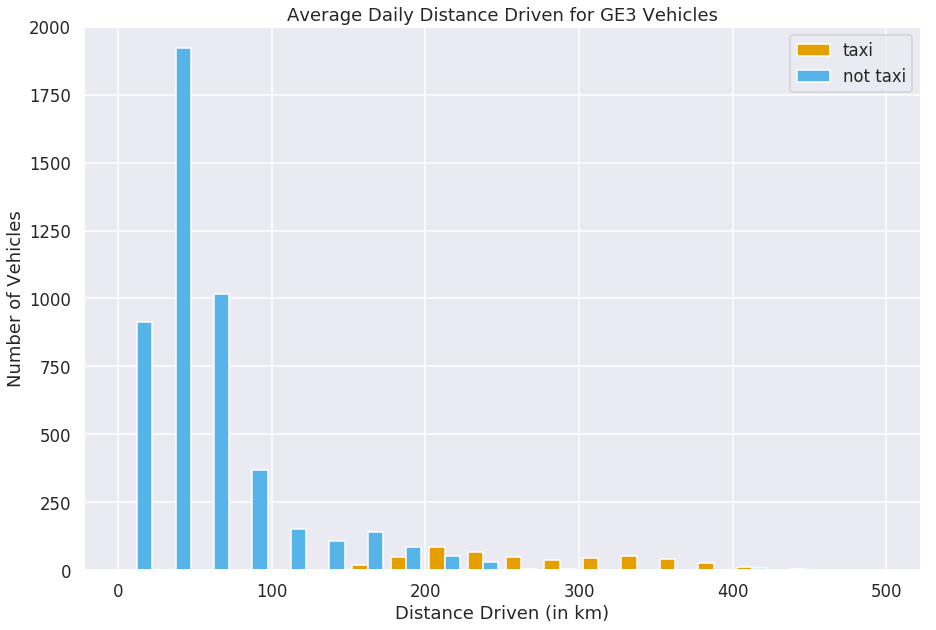

In [37]:
import seaborn as sns
sns.set(rc={"figure.figsize": (15, 10)})
sns.set_context('talk')
import matplotlib.pyplot as plt
plt.figure()
legend=['taxi', 'not taxi']
colors = ['#E69F00', '#56B4E9']
plt.hist([pd_t['Distance Driven'], pd_n['Distance Driven']], color=colors, 
         bins=20, range=[0, 500], histtype='bar')
plt.legend(legend)
plt.ylim((0,2000))
plt.xlabel('Distance Driven (in km)')
plt.ylabel('Number of Vehicles')
plt.title("Average Daily Distance Driven for GE3 Vehicles")
plt.show()

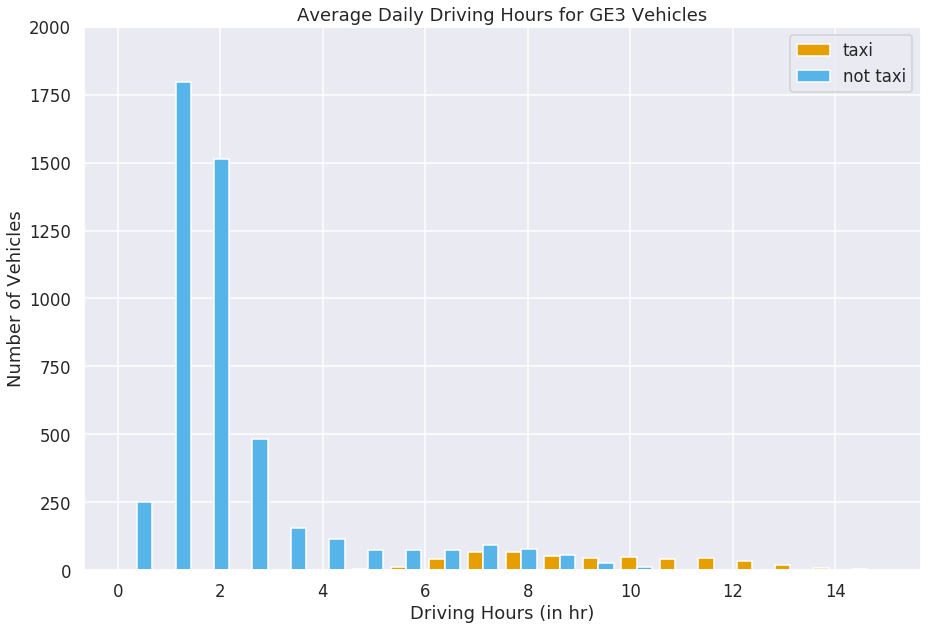

In [38]:
import seaborn as sns
sns.set(rc={"figure.figsize": (15, 10)})
sns.set_context('talk')
import matplotlib.pyplot as plt
plt.figure()
legend=['taxi', 'not taxi']
colors = ['#E69F00', '#56B4E9']
plt.hist([pd_t['Driving Hours'], pd_n['Driving Hours']], color=colors, 
         bins=20, range=[0, 15], histtype='bar')
plt.legend(legend)
plt.ylim((0,2000))
plt.xlabel('Driving Hours (in hr)')
plt.ylabel('Number of Vehicles')
plt.title("Average Daily Driving Hours for GE3 Vehicles")
plt.show()

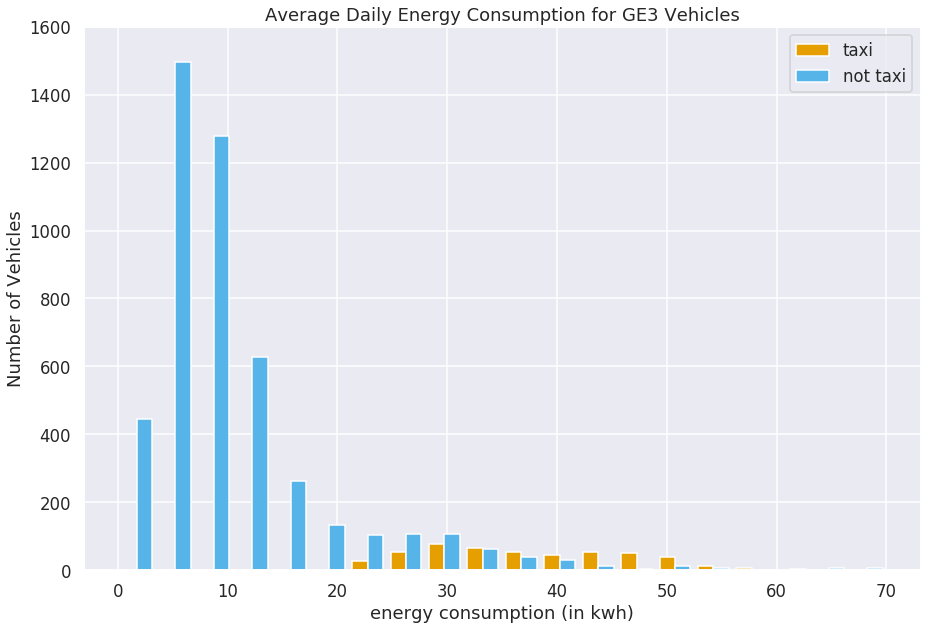

In [46]:
import seaborn as sns
sns.set(rc={"figure.figsize": (15, 10)})
sns.set_context('talk')
import matplotlib.pyplot as plt
plt.figure()
legend=['taxi', 'not taxi']
colors = ['#E69F00', '#56B4E9']
plt.hist([pd_t['kwh consumption'], pd_n['kwh consumption']], color=colors, 
         bins=20, range=[0, 70], histtype='bar')
plt.legend(legend)
plt.ylim((0,1600))
plt.xlabel('energy consumption (in kwh)')
plt.ylabel('Number of Vehicles')
plt.title("Average Daily Energy Consumption for GE3 Vehicles")
plt.show()

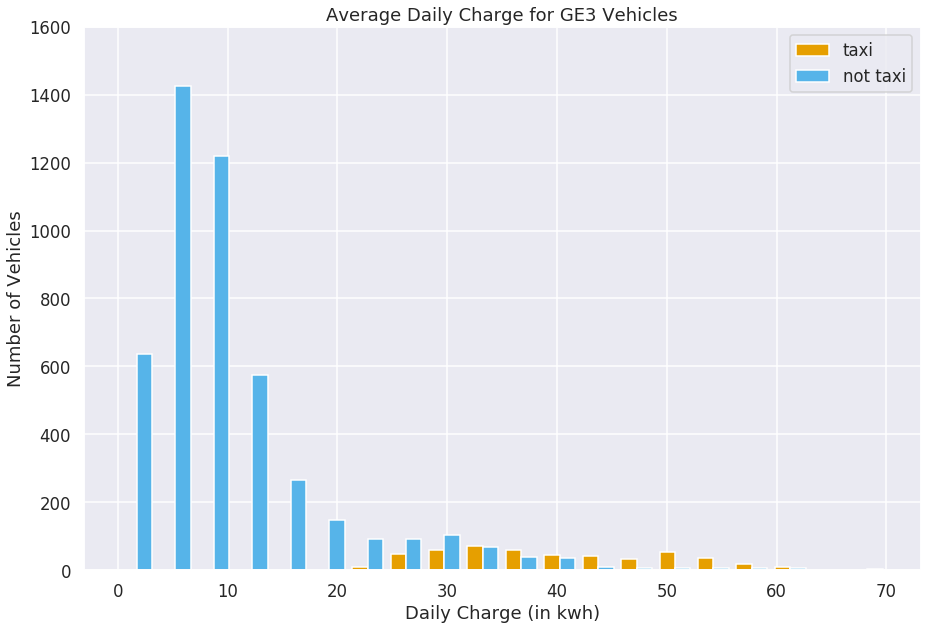

In [47]:
import seaborn as sns
sns.set(rc={"figure.figsize": (15, 10)})
sns.set_context('talk')
import matplotlib.pyplot as plt
plt.figure()
legend=['taxi', 'not taxi']
colors = ['#E69F00', '#56B4E9']
plt.hist([pd_t['kwh_charged_plugin'], pd_n['kwh_charged_plugin']], color=colors, 
         bins=20, range=[0, 70], histtype='bar')
plt.legend(legend)
plt.ylim((0,1600))
plt.xlabel('Daily Charge (in kwh)')
plt.ylabel('Number of Vehicles')
plt.title("Average Daily Charge for GE3 Vehicles")
plt.show()